In [1]:
import argparse
import logging
import time
import ast

import common
import cv2
import numpy as np
#from estimator import TfPoseEstimator
#from networks import get_graph_path, model_wh

from lifting.prob_model import Prob3dPose
from lifting.draw import plot_pose

import os

from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh
import scripts_label.label_image as label_img
import scripts_label.label_image_scene as label_img_scene

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 12)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
#plt.style.use('ggplot')
%matplotlib inline

In [3]:
def resize(img):
    scale_percent = 100 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

In [4]:
#logger = logging.getLogger('TfPoseEstimator')
#logger.setLevel(logging.DEBUG)
#ch = logging.StreamHandler()
#ch.setLevel(logging.DEBUG)
#formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
#ch.setFormatter(formatter)
#logger.addHandler(ch)




In [18]:
def process(img):
    w, h = model_wh('432x368')
    e = TfPoseEstimator(get_graph_path('mobilenet_thin'), target_size=(w, h))

    scene_class = label_img_scene.classify(img)
    
    image = cv2.imread(img)
    #logger.info('cam image=%dx%d' % (image.shape[1], image.shape[0]))
    #logger.debug('+image processing+')
    #logger.debug('+postprocessing+')
    start_time = time.time()
    
    # resize image
    image = resize(image)
    humans = e.inference(image,upsample_size=4.0)
    img = TfPoseEstimator.draw_humans(image, humans,imgcopy=False)

    #logger.debug('+classification+')
    
    # Getting only the skeletal structure (with white background) of the actual image
    image = np.zeros(image.shape,dtype=np.uint8)
    image.fill(255) 
    image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)
    
    # Classification
    pose_class = label_img.classify(image)
    
    end_time = time.time()
    #logger.debug('+displaying+') 


    cv2.putText(img,"Predicted Pose: %s" %(pose_class),(10, 10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0, 0, 255), 2)
    #cv2.putText(img,"Predicted Scene: %s" %(scene_class),(10, 30),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    print('\n Overall Evaluation time (1-image): {:.3f}s\n'.format(end_time-start_time))
    cv2.imwrite('show1.png',img)
    cv2.imshow('tf-human-action-classification result', img)
    cv2.waitKey(0)
    #logger.debug('+finished+')
    cv2.destroyAllWindows()
    
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    plt.imshow(img[:, :, ::-1])
    plt.title("Predicted Scene: %s"%(scene_class)+"  Predicted Pose: %s" %(pose_class))
   #plt.title("Predicted Pose: %s" %(pose_class))


    #3D Plotting
    #plt.add_subplot(2,2,figsize=(15,15))
    fig = plt.figure(figsize=(8,8))
    a = fig.add_subplot(2, 2, 1)
    a.set_title('Result')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    bgimg = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)
    bgimg = cv2.resize(bgimg, (e.heatMat.shape[1], e.heatMat.shape[0]), interpolation=cv2.INTER_AREA)

    # show network output
    a = fig.add_subplot(2, 2, 2)
    plt.imshow(bgimg, alpha=0.5)
    tmp = np.amax(e.heatMat[:, :, :-1], axis=2)
    plt.imshow(tmp, cmap=plt.cm.gray, alpha=0.5)
    plt.colorbar()

    tmp2 = e.pafMat.transpose((2, 0, 1))
    tmp2_odd = np.amax(np.absolute(tmp2[::2, :, :]), axis=0)
    tmp2_even = np.amax(np.absolute(tmp2[1::2, :, :]), axis=0)

    a = fig.add_subplot(2, 2, 3)
    a.set_title('Vectormap-x')
    # plt.imshow(CocoPose.get_bgimg(inp, target_size=(vectmap.shape[1], vectmap.shape[0])), alpha=0.5)
    plt.imshow(tmp2_odd, cmap=plt.cm.gray, alpha=0.5)
    plt.colorbar()

    a = fig.add_subplot(2, 2, 4)
    a.set_title('Vectormap-y')
    # plt.imshow(CocoPose.get_bgimg(inp, target_size=(vectmap.shape[1], vectmap.shape[0])), alpha=0.5)
    plt.imshow(tmp2_even, cmap=plt.cm.gray, alpha=0.5)
    plt.colorbar()
    plt.show()
    
    poseLifting = Prob3dPose('./lifting/models/prob_model_params.mat')

    image_h, image_w = image.shape[:2]
    standard_w = 640
    standard_h = 480

    pose_2d_mpiis = []
    visibilities = []
    for human in humans:
        pose_2d_mpii, visibility = common.MPIIPart.from_coco(human)
        pose_2d_mpiis.append([(int(x * standard_w + 0.5), int(y * standard_h + 0.5)) for x, y in pose_2d_mpii])
        visibilities.append(visibility)

    pose_2d_mpiis = np.array(pose_2d_mpiis)
    visibilities = np.array(visibilities)
    transformed_pose2d, weights = poseLifting.transform_joints(pose_2d_mpiis, visibilities)
    pose_3d = poseLifting.compute_3d(transformed_pose2d, weights)
    #print("17 points of x-coordinates,y-coordinates,z-coordinates in 3 lists...'matplotlib version'")
    #print('\n')
    #print(pose_3d)
    #print('\n')
    
    pose_3dqt = np.array(pose_3d[0]).transpose()
    #print("17 lists containing each point coordinates as a single list...(pyqt format for printing 3d pose")
    #print('\n')
    #for point in pose_3dqt:
        #print(point)
    plt.rcParams["figure.figsize"] = (3,3)
    for i, single_3d in enumerate(pose_3d):
        plot_pose(single_3d)
    plt.show()

    pass


    #three_d(image)
    

[2020-10-27 18:21:14,169] [TfPoseEstimator] [INFO] loading graph from C:\Users\singh\Downloads\tf-pose\src\models\graph/mobilenet_thin/graph_opt.pb(default size=432x368)









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






Evaluation time (1-image): 0.811s

waving hands (score=0.37948)
taking photos (score=0.14546)
applauding (score=0.13766)
texting message (score=0.08382)
smoking (score=0.04915)

Evaluation time (1-image): 0.310s


 Overall Evaluation time (1-image): 0.862s



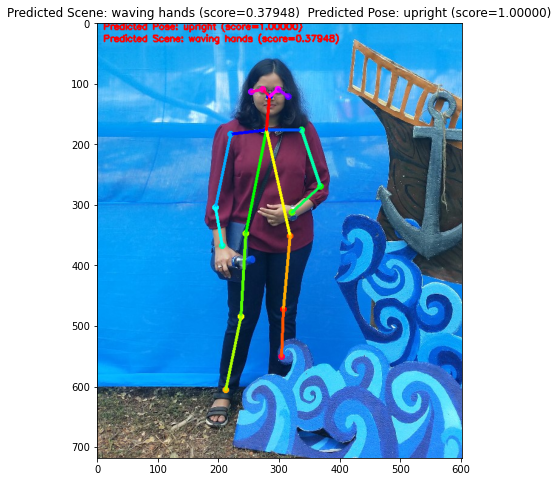

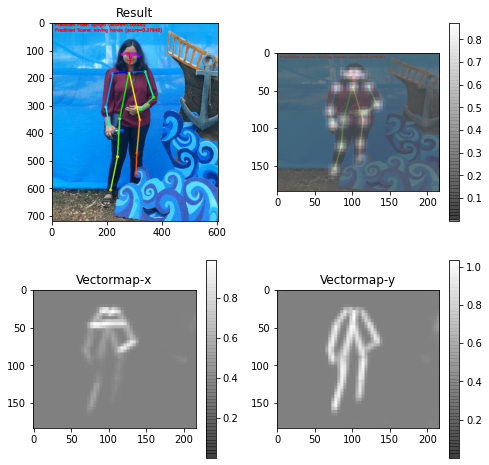

C:\Users\singh\Downloads\tf-pose\src\lifting\upright_fast.py:206: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  p_copy.T, res[j].T)


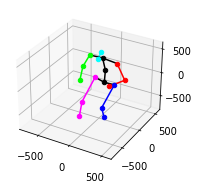

In [6]:
process('pic2.jpeg')

[2020-10-27 18:26:10,379] [TfPoseEstimator] [INFO] loading graph from C:\Users\singh\Downloads\tf-pose\src\models\graph/mobilenet_thin/graph_opt.pb(default size=432x368)



Evaluation time (1-image): 0.626s

phoning (score=0.30099)
waving hands (score=0.20850)
smoking (score=0.13620)
reading (score=0.08513)
jumping (score=0.06782)

Evaluation time (1-image): 0.189s


 Overall Evaluation time (1-image): 0.720s



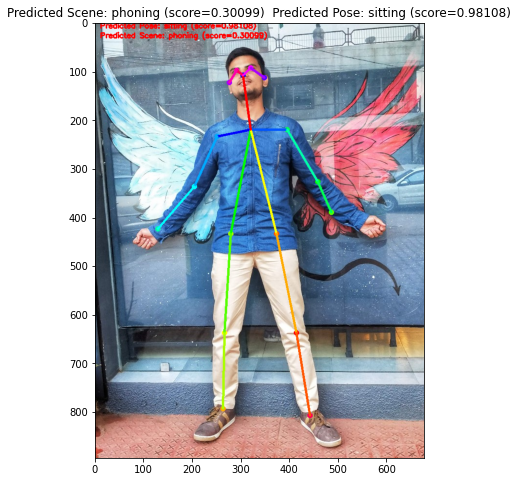

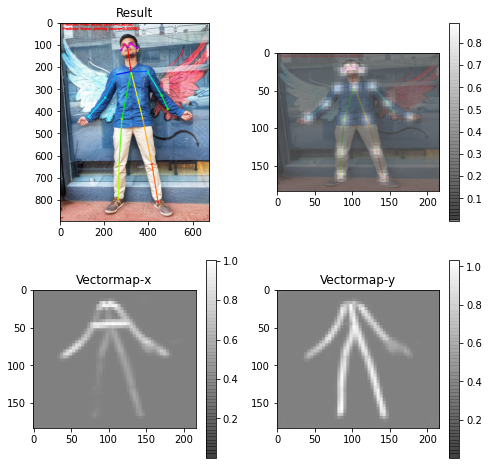

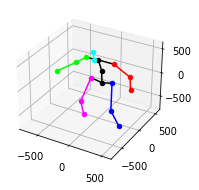

In [7]:
process('pic3.jpeg')

[2020-10-27 18:27:25,076] [TfPoseEstimator] [INFO] loading graph from C:\Users\singh\Downloads\tf-pose\src\models\graph/mobilenet_thin/graph_opt.pb(default size=432x368)



Evaluation time (1-image): 0.543s

texting message (score=0.86250)
taking photos (score=0.03420)
phoning (score=0.02351)
pouring liquid (score=0.01726)
looking through a microscope (score=0.01285)

Evaluation time (1-image): 0.183s


 Overall Evaluation time (1-image): 0.727s



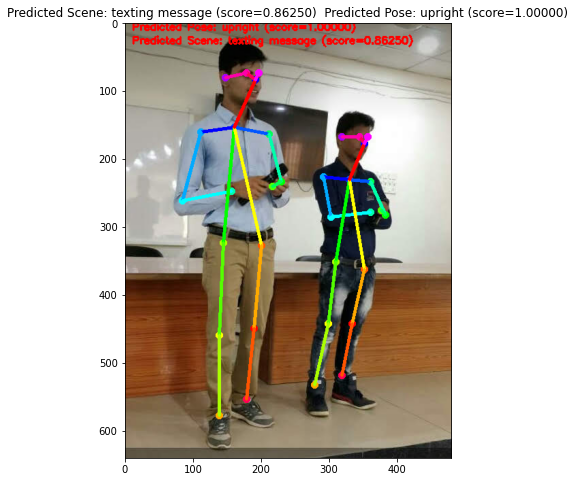

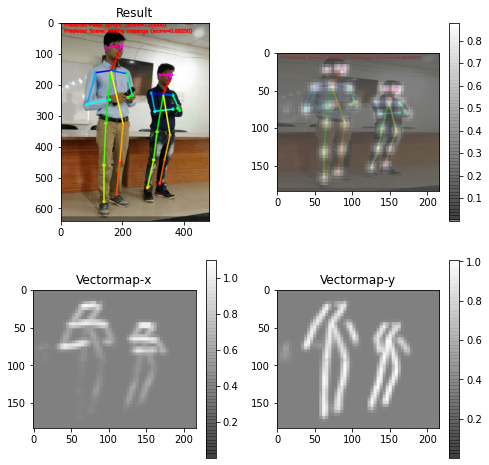

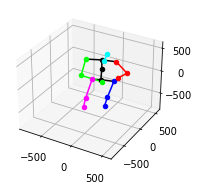

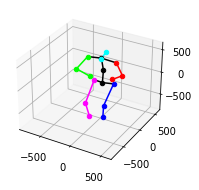

In [8]:
process('pic4.jpeg')

[2020-10-27 20:59:09,293] [TfPoseEstimator] [INFO] loading graph from C:\Users\singh\Downloads\tf-pose\src\models\graph/mobilenet_thin/graph_opt.pb(default size=432x368)



Evaluation time (1-image): 0.570s

riding a bike (score=0.95849)
fixing a bike (score=0.03849)
gardening (score=0.00087)
running (score=0.00030)
waving hands (score=0.00027)

Evaluation time (1-image): 0.234s


 Overall Evaluation time (1-image): 2.091s



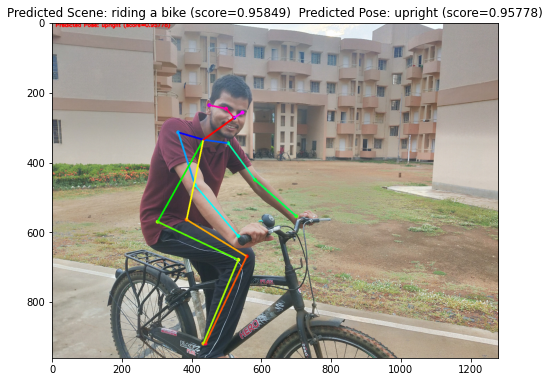

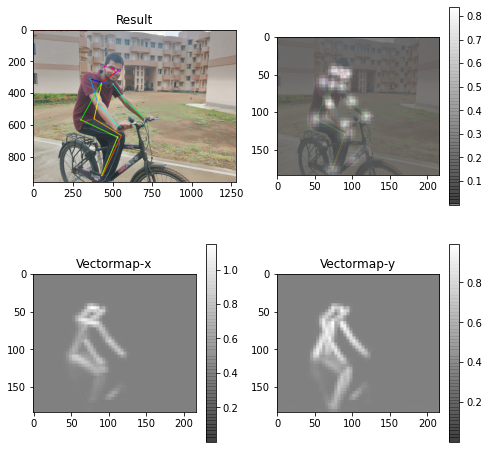

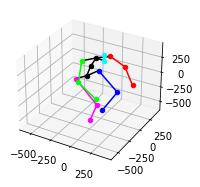

In [20]:
process('pic5.jpeg')

[2020-10-27 18:32:26,886] [TfPoseEstimator] [INFO] loading graph from C:\Users\singh\Downloads\tf-pose\src\models\graph/mobilenet_thin/graph_opt.pb(default size=432x368)



Evaluation time (1-image): 0.609s

reading (score=0.23930)
phoning (score=0.22759)
applauding (score=0.08894)
jumping (score=0.08491)
writing on a book (score=0.06390)

Evaluation time (1-image): 0.192s


 Overall Evaluation time (1-image): 1.154s



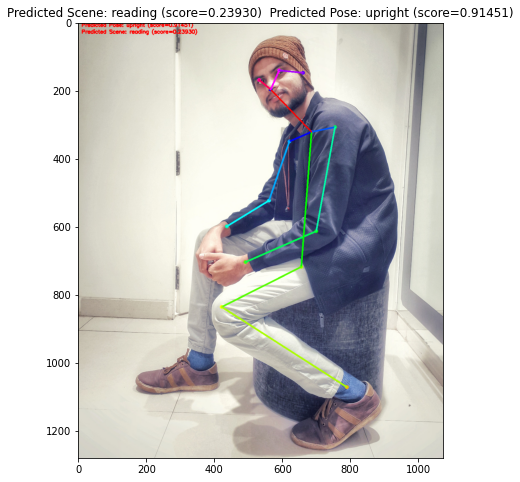

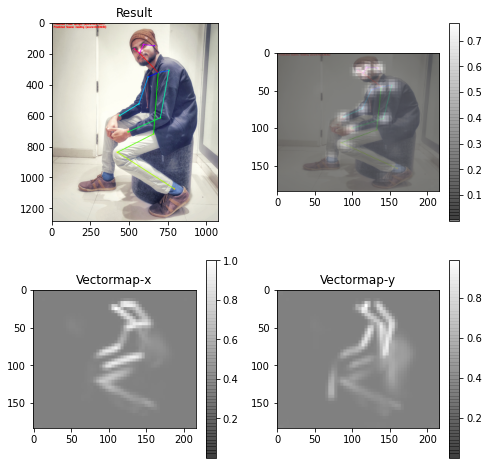

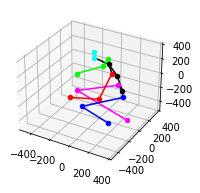

In [10]:
process('pic6.jpeg')

[2020-10-27 18:50:41,428] [TfPoseEstimator] [INFO] loading graph from C:\Users\singh\Downloads\tf-pose\src\models\graph/mobilenet_thin/graph_opt.pb(default size=432x368)



Evaluation time (1-image): 0.548s

brushing teeth (score=0.21123)
waving hands (score=0.18207)
running (score=0.10803)
jumping (score=0.06071)
smoking (score=0.04985)

Evaluation time (1-image): 0.187s


 Overall Evaluation time (1-image): 1.018s



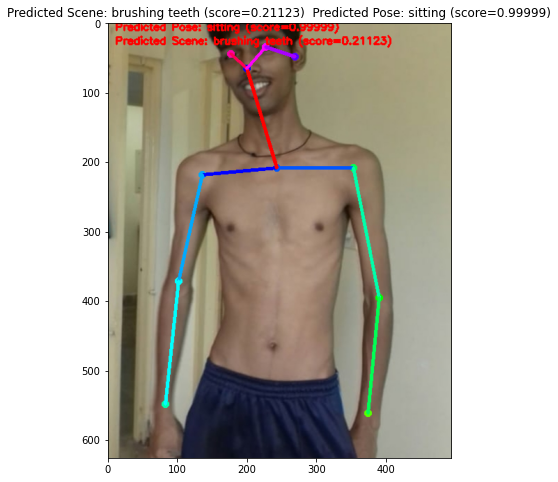

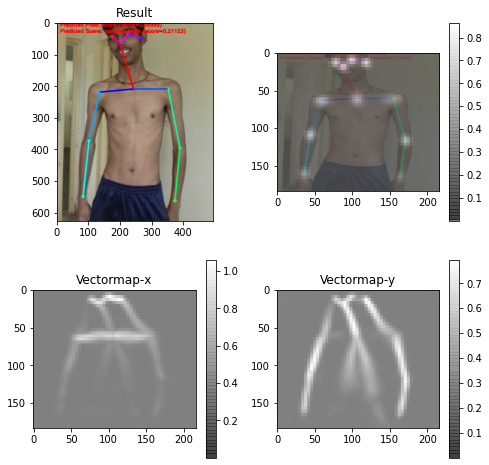

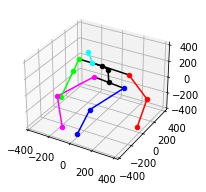

In [13]:
process('p3.jpg')

[2020-10-27 19:21:07,943] [TfPoseEstimator] [INFO] loading graph from C:\Users\singh\Downloads\tf-pose\src\models\graph/mobilenet_thin/graph_opt.pb(default size=432x368)



Evaluation time (1-image): 0.551s

waving hands (score=0.28788)
fixing a car (score=0.15814)
phoning (score=0.14926)
drinking (score=0.10573)
applauding (score=0.05945)

Evaluation time (1-image): 0.206s


 Overall Evaluation time (1-image): 1.223s



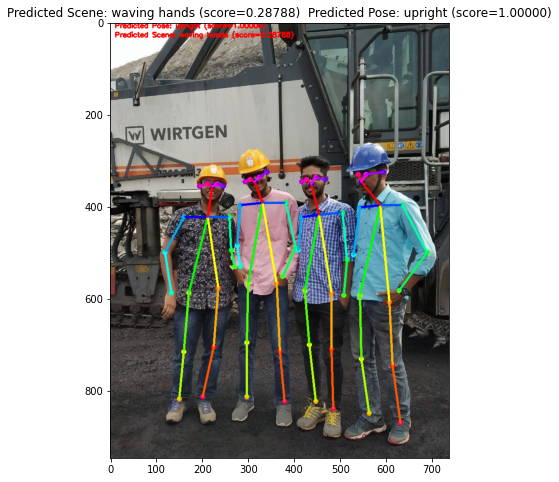

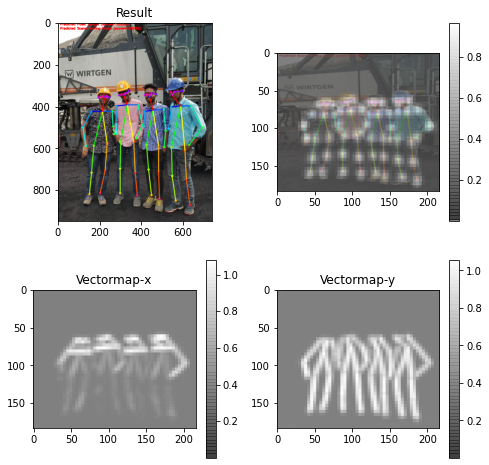

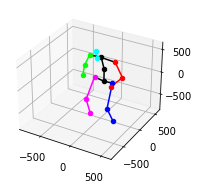

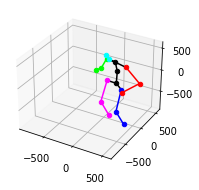

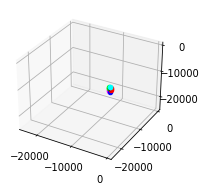

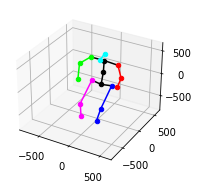

In [14]:
process('pic8.jpg')

[2020-10-27 19:23:27,467] [TfPoseEstimator] [INFO] loading graph from C:\Users\singh\Downloads\tf-pose\src\models\graph/mobilenet_thin/graph_opt.pb(default size=432x368)



Evaluation time (1-image): 0.561s

cutting trees (score=0.34676)
climbing (score=0.19522)
pouring liquid (score=0.09505)
gardening (score=0.08186)
drinking (score=0.04870)

Evaluation time (1-image): 0.192s


 Overall Evaluation time (1-image): 1.395s



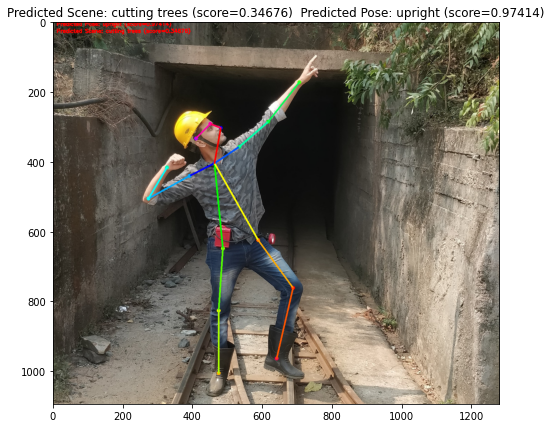

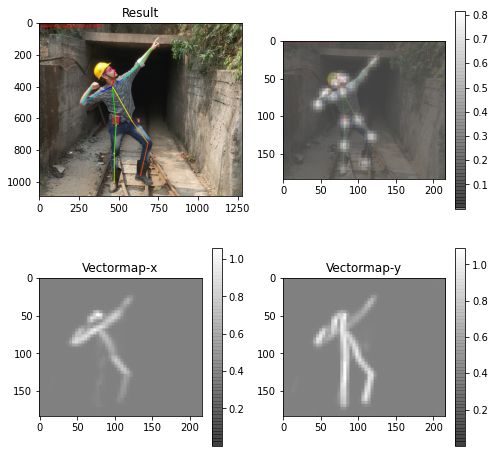

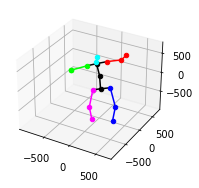

In [15]:
process('pic7.jpeg')

[2020-10-27 19:40:03,322] [TfPoseEstimator] [INFO] loading graph from C:\Users\singh\Downloads\tf-pose\src\models\graph/mobilenet_thin/graph_opt.pb(default size=432x368)



Evaluation time (1-image): 0.629s

phoning (score=0.39456)
brushing teeth (score=0.20333)
smoking (score=0.18560)
waving hands (score=0.09158)
texting message (score=0.07291)

Evaluation time (1-image): 0.248s


 Overall Evaluation time (1-image): 2.269s



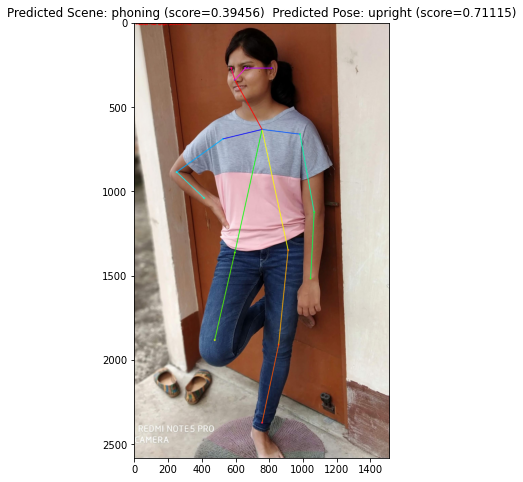

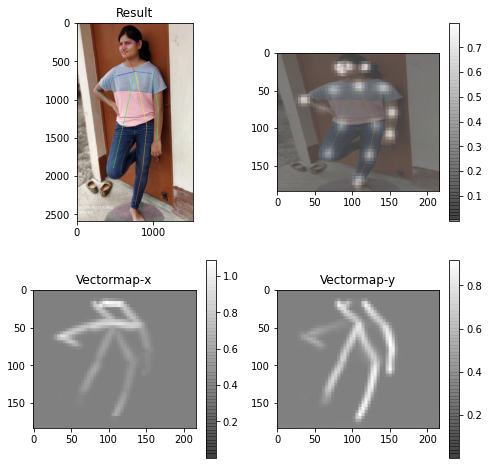

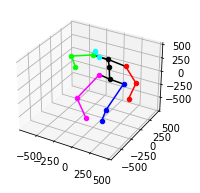

In [19]:
process('p4.jpg')